# Generating phosim catalogs from augmented PanSTARRS data
<br>Owner(s): **Andy Connolly** (@connolly)
<br>Last Verified to Run: **2021-02-12**
<br>Verified Stack Release: **NA**

Query the 'aos_catalog_ps1' table in the 'lsstdevaosdb1' database at NCSA to select sources (assumed to be point sources) and return a Pandas catalog. Write pandas catalog into the file format required by phosim (for images or an OPD). Note we do not set MJD or any of the other parameters required to set a non-dark sky background.

### Logistics
This notebook is intended to be run on the LSP `https://lsst-lsp-stable.ncsa.illinois.edu/nb' The connection information is
<br>
dbName = 'lsstdevaosdb1'<br>
host = 'lsst-pgsql03.ncsa.illinois.edu'<br>
dbuser = 'aconnoll'<br>
dbport = 5432<br>

See [community](https://community.lsst.org/t/using-postgresql-at-ncsa-for-an-apdb/4603) for details on setting up a .pgpass file (required for password to log in to database)

In [1]:
import psycopg2
dbName = 'lsstdevaosdb1'
host = 'lsst-pgsql03.ncsa.illinois.edu'
dbuser = 'aconnoll'
dbport = 5432
dbTable = 'aos_catalog_ps1'

connection = psycopg2.connect(dbname=dbName,
                              host=host,
                              port=dbport,
                              )

In [2]:
#query database for sources within a given radius and return as a pandas dataframe
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

ra = 287.9869104
dec = -30.0748496
radius = 2.
passband = "rmeanpsfmag"

queryString ='SELECT "objid", "ra", "dec", "{}" from "aos_catalog_ps1" where "ra" between {} and {} \
and "dec" between {} and {} and "rmeanpsfmag" > -900.;'.format(passband, ra-radius/np.cos(np.radians(dec)), 
                                                               ra+radius/np.cos(np.radians(dec)), 
                                                               dec-radius, dec+radius)

pandaCat = pd.read_sql_query(queryString, connection)

In [3]:
pandaCat.head(10)

,objid,ra,dec,rmeanpsfmag
0,70062856765403344,285.676545,-31.614174,17.235001
1,70052856777149998,285.677728,-31.616952,18.356001
2,70052856781730257,285.678175,-31.625079,17.722000
3,70062856808353393,285.680841,-31.614129,17.767000
4,70062856844441799,285.684449,-31.615459,17.273001
5,70042856895055399,285.689495,-31.629131,16.361000
6,70052856940279164,285.694026,-31.617650,17.871000
7,70062856952882819,285.695276,-31.614607,16.533001
8,70042856954692650,285.695457,-31.631422,14.887000
9,70042856958826686,285.695869,-31.628038,17.854000


### Plot magnitude histogram of selected region

array([[<AxesSubplot:title={'center':'rmeanpsfmag'}>]], dtype=object)

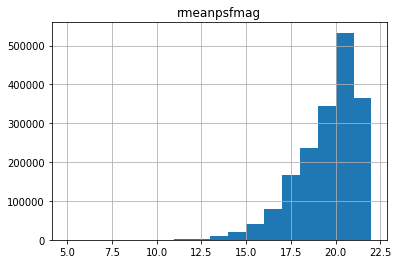

In [9]:
pandaCat.hist(passband,bins=[x for x in np.arange(5.,23.,1.)])

In [4]:
import os
passbands = {"u":"umeanpsfmag", "g":"gmeanpsfmag", "r":"rmeanpsfmag", 
             "i":"imeanpsfmag", "z":"zmeanpsfmag", "y":"ymeanpsfmag", }

def writePhosimHeader(output, ra, dec, camconfig=3, Opsim_filter=3, mjd=59580.):
    '''Write to file handle the phosim header'''
    output.write("Opsim_obshistid {}\n".format(9006002))
    output.write("Opsim_filter {}\n".format(Opsim_filter))
    output.write("mjd {}\n".format(mjd))
    output.write("SIM_SEED {}\n".format(1000))
    output.write("rightascension {}\n".format(ra))
    output.write("declination {}\n".format(dec))
    output.write("rotskypos {}\n".format(0.000000))
    output.write("rottelpos {}\n".format(0))
    output.write("SIM_VISTIME {}\n".format(0.25))
    output.write("SIM_NSNAP {}\n".format(1))
    output.write("moonphase {}\n".format(0.0))
    output.write("moonalt {}\n".format(-90))
    output.write("sunalt {}\n".format(-90))
    output.write("Opsim_rawseeing {}\n".format(-1))
    output.write("camconfig {}\n".format(camconfig))

def writePhosimCatalog(pandaCat, ra, dec, radius, phosimFile="stars.cat", passband='r', outDir="./", camconfig=3, opd=False):
    '''Generate a phosim instance catalog from a Pandas dataframe'''
    outFile = os.path.join(outDir, phosimFile)

    #filter catalog
    filterID = list(passbands.keys()).index(passband)
    with open(outFile,'w') as output:
        writePhosimHeader(output, ra, dec, camconfig=camconfig, Opsim_filter=filterID, mjd=59580.)
        if (opd==True):
            output.write("opd 0 {} {} 500".format(ra,dec))
        else:
            for index, row in pandaCat.iterrows():
                output.write("object {} {} {} {} ../sky/sed_flat.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 12.0 none none\n".format(
                    int(row["objid"]),row["ra"],row["dec"], row[passbands[passband]]))

### Running phosim with the catalog (at NCSA)
python [phosim_dir]/phosim.py stars.cat -i lsst -e 1 -c [phosim_dir]/examples/quickbackground  -p 25 -o [outout_dir]


In [5]:
# output pandas catalog as a phosim instance catalog and an opd catalog

path = './'
writePhosimCatalog(pandaCat, ra, dec, radius, phosimFile="stars.cat", passband='r', outDir=path)

writePhosimCatalog(pandaCat, ra, dec, radius, phosimFile="stars.opd", passband='r', outDir=path, opd=True)

### Visualize example image generated by phosim

In [6]:
from astropy.io import fits
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

In [7]:
hdu = fits.open('/project/ajc/aos/phosim_output/lsst_e_9006002_f2_R22_S21_E000.fits.gz')

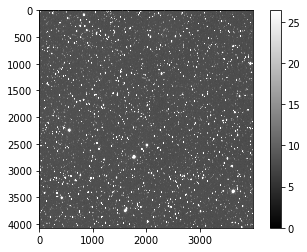

In [8]:
vmin, vmax = zscale.get_limits(hdu[0].data)
plt.imshow(hdu[0].data, vmin=vmin, vmax=vmax, cmap='gray')
plt.colorbar()